In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
from pathlib import Path
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/Users/verakabanova/Desktop/Parsing /parser_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.models as models
model = models.resnet50(pretrained=True)  

In [3]:
DATASET_PATH = 'pexels_architecture_fixed'
DATASET_EMBEDDINGS = 'database_embeddings.npy'
DATASET_PATHS = 'image_paths.npy'
MODEL_NAME = model
IMAGE_SIZE = (224, 224)
TOP_K = 5
print('Start works...')

Start works...


In [4]:
#model = getattr(models, MODEL_NAME)(pretrained= True)

model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()
print(f'Модель загружена и подготовлена')

Модель загружена и подготовлена


2. Определяем функцию для преобразования изображения в вектор...
   Найдено 1000 изображений.
Обработано 50/1000...
Обработано 100/1000...
Обработано 150/1000...
Обработано 200/1000...
Обработано 250/1000...
Обработано 300/1000...
Обработано 350/1000...
Обработано 400/1000...
Обработано 450/1000...
Обработано 500/1000...
Обработано 550/1000...
Обработано 600/1000...
Обработано 650/1000...
Обработано 700/1000...
Обработано 750/1000...
Обработано 800/1000...
Обработано 850/1000...
Обработано 900/1000...
Обработано 950/1000...
Обработано 1000/1000...
   База данных сохранена в 'database_embeddings.npy' (1000 векторов).

4. Определяем функцию для поиска похожих изображений...
5. Загружаем базу данных для быстрого поиска...
Файл '' не найден.

✅ Готово! Система семантического поиска выполнена.

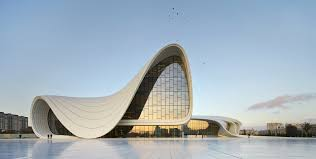

In [22]:
from torch.nn import Embedding
print("2. Определяем функцию для преобразования изображения в вектор...")
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def img_to_embedding(img_path, model, transform):
  try:
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
      embedding = model(img_tensor)

      return embedding.squeeze().cpu().numpy()
  except Exception as e:
    print(f"   Ошибка обработки {img_path}: {e}")
    return None

all_image_paths = []
database_embeddings = []

for ext in ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG'):
    all_image_paths.extend(Path(DATASET_PATH).rglob(ext))

print(f"   Найдено {len(all_image_paths)} изображений.")

for i, img_path in enumerate(all_image_paths):
  emb = img_to_embedding(str(img_path), model, transform)
  if emb is not None:
    database_embeddings.append(emb)

  if (i+1)% 50 ==0:
    print(f'Обработано {i + 1}/{len(all_image_paths)}...')

database_embeddings = np.array(database_embeddings)

np.save(DATASET_EMBEDDINGS, database_embeddings)
np.save(DATASET_PATHS, np.array(all_image_paths))
print(f"   База данных сохранена в '{DATASET_EMBEDDINGS}' ({database_embeddings.shape[0]} векторов).\n")


print("4. Определяем функцию для поиска похожих изображений...")

def find_similar_images(query_img_path, database_embeddings, all_image_paths, model, transform, top_k=TOP_K):
  query_embeddings = img_to_embedding(query_img_path, model, transform)
  if query_embeddings is None:
    print("Не удалось обработать изображение-запрос.")
    return []

  distances = cdist([query_embeddings], database_embeddings, 'cosine')[0]
  similarities = 1 - distances

  top_indices = np.argsort(similarities)[::-1][:top_k]
  results = []
  for idx in top_indices:
    results.append({
        'path': all_paths[idx],
        'similarity': similarities[idx]
    })
    return results

print("5. Загружаем базу данных для быстрого поиска...")

loaded_embeddings = np.load(DATASET_EMBEDDINGS)
loaded_paths = np.load(DATASET_PATHS, allow_pickle=True)

query_path = input("📂 Введите полный путь к изображению-запросу: ").strip()

if not os.path.exists(query_path):
  print(f"Файл '{query_path}' не найден.")
else:
    # Выполняем поиск
    print(f"\n🔍 Ищем {TOP_K} похожих изображений для '{query_path}'...")
    similar_images = find_similar_images(query_path, loaded_embeddings, loaded_paths, model, transform, TOP_K)

    if not similar_images:
        print("Поиск не дал результатов.")
    else:
        print(f"\n🎨 Визуализируем результаты...")

        # Создаём график
        fig, axes = plt.subplots(1, TOP_K + 1, figsize=(3 * (TOP_K + 1), 3))

        # Отображаем изображение-запрос
        query_img = Image.open(query_path).convert('RGB')
        axes[0].imshow(query_img)
        axes[0].set_title("Запрос", fontsize=10)
        axes[0].axis('off')

        # Отображаем найденные похожие изображения
        for i, result in enumerate(similar_images):
            sim_img = Image.open(result['path']).convert('RGB')
            axes[i + 1].imshow(sim_img)
            axes[i + 1].set_title(f"Сходство: {result['similarity']:.3f}", fontsize=9)
            axes[i + 1].axis('off')

        plt.suptitle(f"Топ-{TOP_K} похожих изображений", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Текстовый вывод результатов
        print("\n📋 Результаты поиска (отсортированы по сходству):")
        for i, result in enumerate(similar_images):
            print(f"{i+1:2d}. {result['path']} (сходство: {result['similarity']:.4f})")

print("\n✅ Готово! Система семантического поиска выполнена.")






In [5]:
import matplotlib.pyplot as plt
plt.ion()  # Включаем интерактивный режим (чтобы графики показывались сразу)

In [8]:
# ... ваш предыдущий код с импортами и константами ...

print("🚀 Начинаем работу...")

# ========== 1. СОЗДАЁМ ТРАНСФОРМАЦИИ (ДЛЯ ВСЕГО СКРИПТА) ==========
print("1. Определяем трансформации для изображений...")
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
print("   Трансформации готовы.\n")

# ========== 2. ЗАГРУЖАЕМ МОДЕЛЬ ==========
print(f"2. Загружаем модель {MODEL_NAME}...")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()
print(f"   Модель {MODEL_NAME} загружена и подготовлена.\n")

# ========== 3. ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ЭМБЕДДИНГА ==========
print("3. Определяем функцию для преобразования изображения в вектор...")
def img_to_embedding(img_path, model, transform):
    """Преобразует изображение по пути `img_path` в вектор (эмбеддинг)."""
    # ... тело вашей функции img_to_embedding без изменений ...

# ... далее весь ваш код продолжается ...

🚀 Начинаем работу...
1. Определяем трансформации для изображений...
   Трансформации готовы.

2. Загружаем модель ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

Загружаем модель и базу данных...
✅ База загружена: 1000 изображений


🔍 Ищем 5 похожих изображений...

✅ Предсказанный класс: pexels_architecture_fixed

📋 Топ-5 похожих изображений:
1. pexels_architecture_fixed/arch_0746_18492588.jpg
   Класс: pexels_architecture_fixed, Сходство: 0.7858
2. pexels_architecture_fixed/arch_0480_2908978.jpg
   Класс: pexels_architecture_fixed, Сходство: 0.7734
3. pexels_architecture_fixed/arch_0804_96427.jpg
   Класс: pexels_architecture_fixed, Сходство: 0.7436
4. pexels_architecture_fixed/arch_0850_3881679.jpg
   Класс: pexels_architecture_fixed, Сходство: 0.7325
5. pexels_architecture_fixed/arch_0086_35429443.jpg
   Класс: pexels_architecture_fixed, Сходство: 0.7255

🎨 Создаем коллаж результатов...
📁 Коллаж сохранен как 'search_results.jpg'


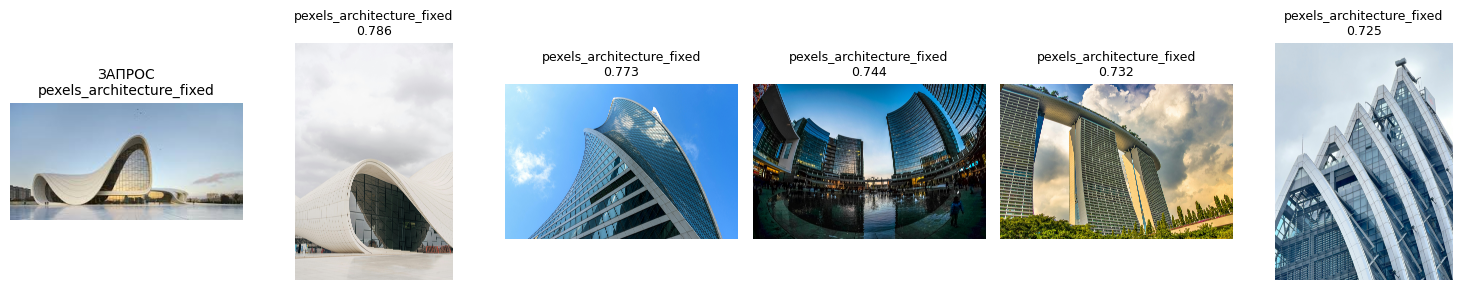


✅ Готово!


In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from pathlib import Path
from scipy.spatial.distance import cdist
import os
import matplotlib.pyplot as plt

# ========== КОНФИГУРАЦИЯ ==========
EMBEDDINGS_FILE = 'database_embeddings.npy'    # Файл с эмбеддингами (уже есть)
PATHS_FILE = 'image_paths.npy'              # Файл с путями (уже есть)
TOP_K = 5                             # Количество похожих фото

# ========== 1. БЫСТРАЯ ИНИЦИАЛИЗАЦИЯ ==========
print("Загружаем модель и базу данных...")

# Устройство для вычислений (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загружаем модель ResNet50 (только для получения эмбеддинга запроса)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model = model.to(device).eval()

# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Загружаем готовую базу данных
embeddings = np.load(EMBEDDINGS_FILE)
paths = np.load(PATHS_FILE, allow_pickle=True)
print(f"✅ База загружена: {len(paths)} изображений")

# ========== 2. ФУНКЦИИ ==========
def get_embedding(img_path):
    """Создает эмбеддинг для одного изображения (запроса)"""
    try:
        img = Image.open(img_path).convert('RGB')
        tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(tensor).squeeze().cpu().numpy().flatten()
        return embedding
    except Exception as e:
        print(f"❌ Ошибка загрузки {img_path}: {e}")
        return None

def get_class(path):
    """Определяет класс из пути (если структура: папка_класса/файл.jpg)"""
    parts = Path(path).parts
    return parts[-2] if len(parts) >= 2 else "unknown"

def search_and_classify(query_path):
    """Основная функция поиска и классификации"""
    # 1. Получаем эмбеддинг запроса
    query_emb = get_embedding(query_path)
    if query_emb is None:
        return None, "error"
    
    # 2. Ищем похожие в базе
    similarities = 1 - cdist([query_emb], embeddings, 'cosine')[0]
    top_ids = np.argsort(similarities)[-TOP_K:][::-1]
    
    # 3. Собираем результаты и голосуем за класс
    results = []
    class_votes = {}
    
    for idx in top_ids:
        path = paths[idx]
        cls = get_class(path)
        results.append({
            'path': path,
            'class': cls,
            'similarity': similarities[idx]
        })
        class_votes[cls] = class_votes.get(cls, 0) + 1
    
    # 4. Определяем класс запроса (самый частый среди найденных)
    pred_class = max(class_votes.items(), key=lambda x: x[1])[0] if class_votes else "unknown"
    return results, pred_class

# ========== 3. ЗАПУСК ПОИСКА ==========
print("\n" + "="*50)
query_path = input("📂 Введите путь к вашему изображению: ").strip()

if os.path.exists(query_path):
    print(f"\n🔍 Ищем {TOP_K} похожих изображений...")
    results, pred_class = search_and_classify(query_path)
    
    if results:
        print(f"\n✅ Предсказанный класс: {pred_class}")
        print("\n📋 Топ-5 похожих изображений:")
        for i, r in enumerate(results, 1):
            print(f"{i}. {r['path']}")
            print(f"   Класс: {r['class']}, Сходство: {r['similarity']:.4f}")
        
        # ========== 4. СОЗДАНИЕ КОЛЛАЖА ==========
        print("\n🎨 Создаем коллаж результатов...")
        fig, axes = plt.subplots(1, TOP_K + 1, figsize=(15, 3))
        
        # Показываем запрос
        query_img = Image.open(query_path).convert('RGB')
        axes[0].imshow(query_img)
        axes[0].set_title(f"ЗАПРОС\n{pred_class}", fontsize=10)
        axes[0].axis('off')
        
        # Показываем результаты
        for i, r in enumerate(results):
            img = Image.open(r['path']).convert('RGB')
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"{r['class']}\n{r['similarity']:.3f}", fontsize=9)
            axes[i+1].axis('off')
        
        plt.tight_layout()
        
        # Сохраняем и показываем
        output_file = "search_results.jpg"
        plt.savefig(output_file, dpi=150, bbox_inches='tight')
        print(f"📁 Коллаж сохранен как '{output_file}'")
        plt.show()
        
    else:
        print("❌ Поиск не дал результатов.")
else:
    print(f"❌ Файл '{query_path}' не найден!")

print("\n✅ Готово!")

In [1]:
import torch
import clip
from PIL import Image
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


/Users/verakabanova/Desktop/Parsing /parser_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


==== Конфигурация =====

In [11]:
DATASET_PATH = 'pexels_architecture_fixed'
EMBEDDINGS_FILE = 'database_embeddings.npy'
PATHS_FILE = 'image_paths.npy'
TOP_K = 5 
MODEL_NAME = 'ViT-B/32'

====== Инициализация CLIP =====

In [12]:
divice = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load(MODEL_NAME, device=divice)
model.eval()
print(f'Загружена модель CLIP: {MODEL_NAME} на {divice}')

Загружена модель CLIP: ViT-B/32 на cpu


==== Функция для эмбуддингов ====

In [19]:
def get_image_embedding(img_path):
    try:
        image = Image.open(img_path).convert('RGB')
        image_input = preprocess(image).unsqueeze(0).to(divice)
        with torch.no_grad():
            embedding = model.encode_image(image_input)
            embedding /= embedding.norm(dim=-1, keepdim=True)

        embedding_np = embedding.cpu().numpy().flatten()

        print(f"DEBUG get_image_embedding: {embedding_np.shape}")  # Должно быть (512,) или (768,)
        return embedding_np
    except Exception as e:
        print(f"❌ Ошибка: {img_path} - {e}")
        return None
    
def get_text_embedding(text_query):
    text_input = clip.tokenize([f'a photo of {text_query}']).to(divice)
    with torch.no_grad():
        embedding = model.encode_text(text_input)
        embedding /= embedding.norm(dim=-1, keepdim=True)
    return embedding.cpu().numpy()


def create_database():
    all_paths = []
    for ext in ('*jpg', '*jpeg', '*png'):
        all_paths.extend(Path(DATASET_PATH).rglob(ext))

    print(f'Найдено {len(all_paths)} изображений. Создание эмбеддингов ...')

    embeddings =[]
    valid_paths = []

    for i, img_path in enumerate(all_paths):
        emb = get_image_embedding(str(img_path))
        if emb is not None:
            emb_flat = emb.flatten()
            embeddings.append(emb_flat)
            valid_paths.append(str(img_path))

        if (i+1)% 50 ==0:
            print(f'Обработка {i+1}/ {len(all_paths)}....')


    embeddings = np.vstack(embeddings)
    np.save(EMBEDDINGS_FILE, embeddings)
    np.save(PATHS_FILE, np.array(valid_paths))

    print(f'База создана: {embeddings.shape[0]} эмбеддингов')

    return embeddings, np.array(valid_paths)

==== Функция поиска =====

In [20]:
def search_by_image(query_img_path, embeddings, paths, top_k=TOP_K):
    query_emb = get_image_embedding(query_img_path)
    if query_emb is None:
        return []
    
    if query_emb.ndim > 1:
        query_emb = query_emb.flatten()
    
    if embeddings.ndim == 1:
        embeddings = embeddings.reshape(1, -1)

    query_emb_2d = query_emb.reshape(1, -1)
    
    # Проверка размерности (должны совпадать)
    if query_emb_2d.shape[0] != embeddings.shape[1]:
        print(f"❌ ОШИБКА: Несовпадение размерности!")
        print(f"   query_emb: {query_emb_2d.shape} (должно быть ({embeddings.shape[1]},))")
        print(f"   embeddings: {embeddings.shape}")
        
        # Автоматическое исправление: обрезаем или дополняем нулями
        min_dim = min(query_emb.shape[0], embeddings.shape[1])
        query_emb = query_emb[:min_dim]
        embeddings = embeddings[:, :min_dim]
        print(f"   Исправлено до: query_emb {query_emb_2d.shape}, embeddings {embeddings.shape}")
    
    similarities = 1 - cdist(query_emb_2d, embeddings, 'cosine')[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]

    return [(paths[idx], similarities[idx]) for idx in top_indices]

def search_by_text(query_text, embeddings, paths, top_k=TOP_K):
    """Поиск изображений по тексту"""
    query_emb = get_text_embedding(query_text)
    
    # Убедимся, что query_emb - плоский вектор
    query_emb = query_emb.flatten()
    
    # Вычисляем сходство через матричное умножение
    similarities = (embeddings @ query_emb).flatten()
    
    # Находим топ-k результатов
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    return [(paths[idx], similarities[idx]) for idx in top_indices]

def zero_shot_classify(image_path, class_descriptions):

    if class_descriptions is None:
        class_descriptions = [
            "modern skyscraper with glass facade",
            "classical building with columns",
            "gothic cathedral with stained glass",
            "traditional wooden house",
            "brutalist concrete structure"
        ]

    image_emb = get_image_embedding(image_path)
    if image_emb is None:
        return []
    
    if image_emb.ndim == 1:
        image_emb = image_emb.reshape(1, -1)
    
    text_inputs = clip.tokenize(class_descriptions).to(divice)
    with torch.no_grad():
        text_embeddings = model.encode_text(text_inputs)
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

    similarity = (100.0 * image_emb @ text_embeddings.T)
    probs = similarity.softmax(dim=-1)
    values, indices = probs[0].topk(min(3, len(class_descriptions)))

    return [(class_descriptions[idx], val.item()) for val, idx in zip(values, indices)] 

==== Интерактивный  интерфейс =====

In [21]:
def display_results(query, results, query_type='image'):
    fig, axes = plt.subplots(1, len(results)+1, figsize =(3 * (len(results)+1), 3))

    if query_type == 'image':
        query_img = Image.open(query).convert('RGB')
        axes[0].imshow(query_img)
        axes[0].set_title('Запрос', fontsize=10)
    else:
        axes[0].text(0.5, 0.5, f'"{query}"', ha='center', va = 'center', fontsize=12)
        axes[0].set_title(' Текстовый запрос', fontsize=10)
        axes[0].axis('off')


    for i, (path, similarity) in enumerate(results):
        img = Image.open(path).convert('RGB')
        axes[i+1].imshow(img)
        axes[i+1].set_title(f' Сходство : {similarity:.3f}', fontsize=9)
        axes[i+1].axis('off')

    plt.suptitle(f'ТОП - {len(results)} результатов', fontsize = 12)
    plt.tight_layout()
    plt.show()

==== Основой блок ====

✅ Загружена CLIP-база: 1000 изображений
📏 Размерность: (1000, 512)

Выберите режим:
1. Поиск по изображению (Image2Image)
2. Поиск по тексту (Text2Image)
3. Классификация без обучения (Zero-Shot)
DEBUG get_image_embedding: (512,)
❌ ОШИБКА: Несовпадение размерности!
   query_emb: (1, 512) (должно быть (512,))
   embeddings: (1000, 512)
   Исправлено до: query_emb (1, 512), embeddings (1000, 512)
 Найдено 5 похожих изображений:
1. arch_0746_18492588.jpg (Сходство: 0.8265)
2. arch_0763_33357743.jpg (Сходство: 0.7650)
3. arch_0151_32820576.jpg (Сходство: 0.7559)
4. arch_0748_19610356.jpg (Сходство: 0.7343)
5. arch_0171_35388179.jpg (Сходство: 0.7236)


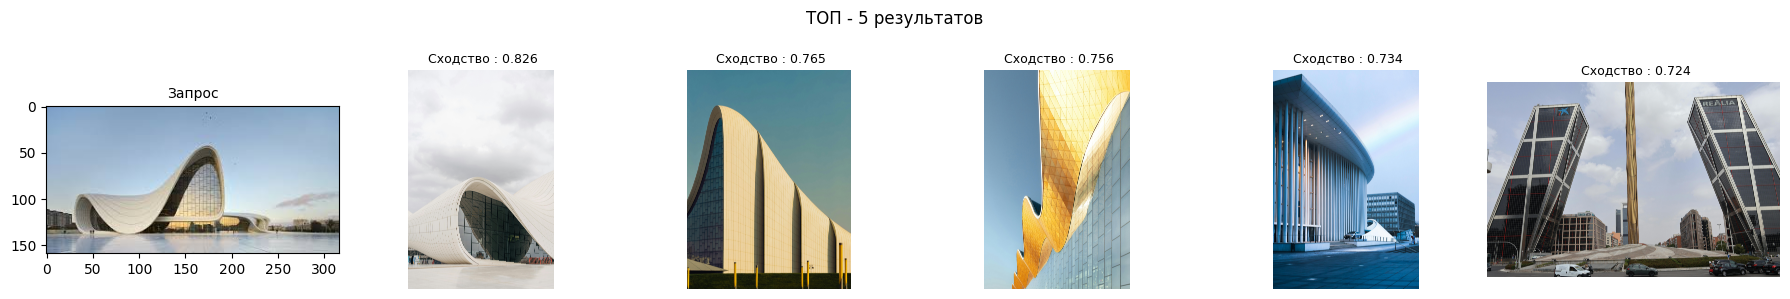

Работа завершена


In [9]:
def recreate_database_with_clip():
    """Пересоздает базу данных с использованием CLIP"""
    print("🔄 Пересоздаем базу данных с CLIP...")
    
    # Удаляем старые файлы, если они есть
    if os.path.exists(EMBEDDINGS_FILE):
        os.remove(EMBEDDINGS_FILE)
    if os.path.exists(PATHS_FILE):
        os.remove(PATHS_FILE)
    
    # Создаем новую базу
    embeddings, paths = create_database()
    print(f"✅ Новая база создана: {embeddings.shape}")
    return embeddings, paths

# В функции main() замените блок загрузки базы:
def main():
    # УДАЛИТЕ старый блок загрузки и используйте ЭТОТ:
    
    if os.path.exists(EMBEDDINGS_FILE) and os.path.exists(PATHS_FILE):
        embeddings = np.load(EMBEDDINGS_FILE)
        paths = np.load(PATHS_FILE, allow_pickle=True)
        
        # Проверяем размерность
        if embeddings.shape[1] == 512:  # CLIP эмбеддинг
            print(f"✅ Загружена CLIP-база: {len(paths)} изображений")
            print(f"📏 Размерность: {embeddings.shape}")
        else:
            print(f"⚠ Обнаружена старая база с размерностью {embeddings.shape[1]}")
            choice = input("Пересоздать базу с CLIP? (y/n): ").strip().lower()
            if choice == 'y':
                embeddings, paths = recreate_database_with_clip()
            else:
                print("❌ Используйте режим 1 только с CLIP-базой")
                return
    else:
        print("⚠ База не найдена. Создаем новую с CLIP...")
        embeddings, paths = create_database()
    
   

    print("\n" + "="*50)
    print("Выберите режим:")
    print("1. Поиск по изображению (Image2Image)")
    print("2. Поиск по тексту (Text2Image)")
    print("3. Классификация без обучения (Zero-Shot)")
    mode = input("Введите номер (1-3): ").strip()

    if mode == '1':
        query_path = input(' Путь к изображению-запросу: ').strip()
        if os.path.exists(query_path):
            results = search_by_image(query_path, embeddings, paths)

            print(f' Найдено {len(results)} похожих изображений:')
            for i , (path, sim) in enumerate(results, 1):
                print(f'{i}. {Path(path).name} (Сходство: {sim:.4f})')
            display_results(query_path, results, 'image')
        else:
            print('Файл не найден')

    elif mode == '2':
        query_text = input(' Текстовый запрос (напр. "modern building"):').strip()
        results = search_by_text(query_text, embeddings, paths)
        print(f"Найдено {len(results)} изображений по запросу '{query_text}': ") 

        for i, (path, sim) in enumerate(results, 1):
            print(f"{i}. {Path(path).name} (релевантность: {sim:.4f})")
        display_results(query_text, results, 'text') 


    elif mode == '3':
        query_path = input("📂 Путь к изображению для классификации: ").strip()
        if os.path.exists(query_path):
            custom_classes = input("✏ Введите классы через запятую (или Enter для стандартных): ").strip()

            if custom_classes:
                class_list = [c.strip() for c in custom_classes.split(',')]
            else:
                class_list = None
            results = zero_shot_classify(query_path, class_list)
            print(f"\n🎯 Результаты классификации:")
            for class_name, confidence in results:
                print(f' {class_name} : {confidence:.2f}')

        else:
            print('Файл не найден')
    else:
        print('Неверный выбор ')
if __name__ == '__main__':
    main()
    print('Работа завершена')


✅ Загружена CLIP-база: 1000 изображений
📏 Размерность: (1000, 512)

Выберите режим:
1. Поиск по изображению (Image2Image)
2. Поиск по тексту (Text2Image)
3. Классификация без обучения (Zero-Shot)
Найдено 5 изображений по запросу 'gothic cathedral': 
1. arch_0017_35445360.jpg (релевантность: 0.2972)
2. arch_0080_35410905.jpg (релевантность: 0.2945)
3. arch_0401_4542984.jpg (релевантность: 0.2877)
4. arch_0639_1213965.jpg (релевантность: 0.2827)
5. arch_0084_35410933.jpg (релевантность: 0.2819)


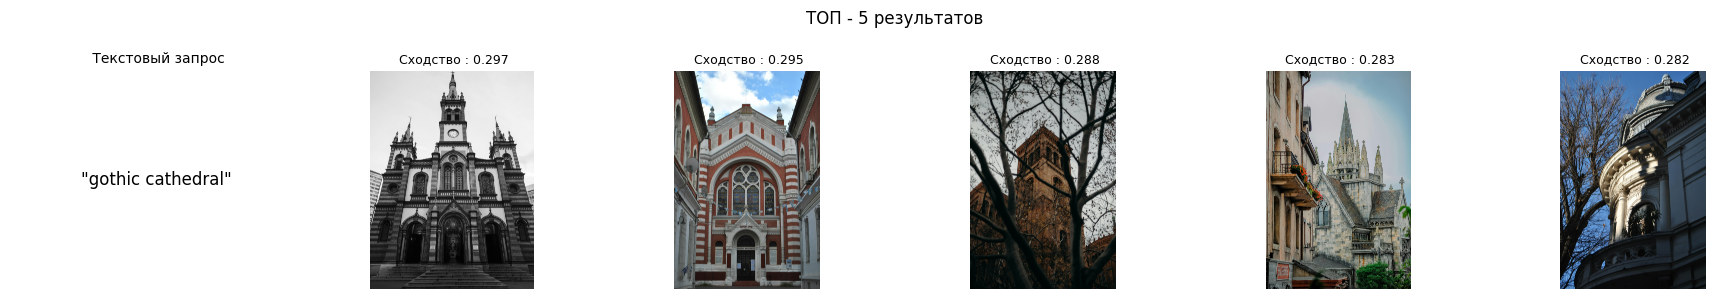

Работа завершена


In [23]:
def recreate_database_with_clip():
    """Пересоздает базу данных с использованием CLIP"""
    print("🔄 Пересоздаем базу данных с CLIP...")
    
    # Удаляем старые файлы, если они есть
    if os.path.exists(EMBEDDINGS_FILE):
        os.remove(EMBEDDINGS_FILE)
    if os.path.exists(PATHS_FILE):
        os.remove(PATHS_FILE)
    
    # Создаем новую базу
    embeddings, paths = create_database()
    print(f"✅ Новая база создана: {embeddings.shape}")
    return embeddings, paths

# В функции main() замените блок загрузки базы:
def main():
    # УДАЛИТЕ старый блок загрузки и используйте ЭТОТ:
    
    if os.path.exists(EMBEDDINGS_FILE) and os.path.exists(PATHS_FILE):
        embeddings = np.load(EMBEDDINGS_FILE)
        paths = np.load(PATHS_FILE, allow_pickle=True)
        
        # Проверяем размерность
        if embeddings.shape[1] == 512:  # CLIP эмбеддинг
            print(f"✅ Загружена CLIP-база: {len(paths)} изображений")
            print(f"📏 Размерность: {embeddings.shape}")
        else:
            print(f"⚠ Обнаружена старая база с размерностью {embeddings.shape[1]}")
            choice = input("Пересоздать базу с CLIP? (y/n): ").strip().lower()
            if choice == 'y':
                embeddings, paths = recreate_database_with_clip()
            else:
                print("❌ Используйте режим 1 только с CLIP-базой")
                return
    else:
        print("⚠ База не найдена. Создаем новую с CLIP...")
        embeddings, paths = create_database()
    
   

    print("\n" + "="*50)
    print("Выберите режим:")
    print("1. Поиск по изображению (Image2Image)")
    print("2. Поиск по тексту (Text2Image)")
    print("3. Классификация без обучения (Zero-Shot)")
    mode = input("Введите номер (1-3): ").strip()

    if mode == '1':
        query_path = input(' Путь к изображению-запросу: ').strip()
        if os.path.exists(query_path):
            results = search_by_image(query_path, embeddings, paths)

            print(f' Найдено {len(results)} похожих изображений:')
            for i , (path, sim) in enumerate(results, 1):
                print(f'{i}. {Path(path).name} (Сходство: {sim:.4f})')
            display_results(query_path, results, 'image')
        else:
            print('Файл не найден')

    elif mode == '2':
        query_text = input(' Текстовый запрос (напр. "modern building"):').strip()
        results = search_by_text(query_text, embeddings, paths)
        print(f"Найдено {len(results)} изображений по запросу '{query_text}': ") 

        for i, (path, sim) in enumerate(results, 1):
            print(f"{i}. {Path(path).name} (релевантность: {sim:.4f})")
        display_results(query_text, results, 'text') 


    elif mode == '3':
        query_path = input("📂 Путь к изображению для классификации: ").strip()
        if os.path.exists(query_path):
            custom_classes = input("✏ Введите классы через запятую (или Enter для стандартных): ").strip()

            if custom_classes:
                class_list = [c.strip() for c in custom_classes.split(',')]
            else:
                class_list = None
            results = zero_shot_classify(query_path, class_list)
            print(f"\n🎯 Результаты классификации:")
            for class_name, confidence in results:
                print(f' {class_name} : {confidence:.2f}')

        else:
            print('Файл не найден')
    else:
        print('Неверный выбор ')
if __name__ == '__main__':
    main()
    print('Работа завершена')


Сводка ключевых концепций
Контрастное обучение: CLIP обучается, связывая похожие пары "изображение-текст" и отдаляя непохожие. Это позволяет модели понимать семантику без явной разметки .

Общее пространство эмбеддингов: Изображения и тексты проецируются в одно векторное пространство, что позволяет вычислять их сходство напрямую .

Косинусное сходство: Используется для измерения близости векторов-запроса и векторов в базе данных.

Zero-shot классификация: Возможность классифицировать объекты по текстовым описаниям без обучения на примерах этих классов 